In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
import gensim

import chardet

from sklearn.metrics import f1_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data=pd.read_csv("/content/drive/My Drive/all_news.csv")

data.columns


Index(['Unnamed: 0', 'news_item', 'text', 'tweets', 'retweet_count',
       'favorite_count', 'is_verified_count', 'mean_time_diff',
       'popularity_score', 'label'],
      dtype='object')

In [0]:
data=data.drop(['Unnamed: 0'],axis=1)
data.head()

,news_item,text,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score,label
0,gossipcop-4669006800,b'The most famous wedding dress of 2018 is rea...,4,0.0,0.0,1.0,869.750000,368348.0,fake
1,gossipcop-899567,b'Kendall Jenner is keeping warm this season!T...,51,0.0,0.0,0.0,1110.764706,43386.0,real
2,gossipcop-852794,b'[This story contains spoilers from Agents of...,1,0.0,0.0,0.0,942.000000,-233.0,real
3,gossipcop-909114,b'EXCLUSIVE: Casey Affleck has withdrawn from ...,61,0.0,0.0,0.0,977.918033,61693.0,real
4,gossipcop-908296,"b""They starred together as father and son in a...",48,0.0,0.0,0.0,982.708333,56.0,real


In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
Stop_Words=stopwords.words()

y=data.label
data=data.drop("label",axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=53)

cv=CountVectorizer(stop_words='english')
count_train=cv.fit_transform(x_train["text"]) 
count_test=cv.transform(x_test["text"])

tf=TfidfVectorizer(stop_words='english')
tf_train=tf.fit_transform(x_train["text"]) 
tf_test=tf.transform(x_test["text"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
data.head()

,news_item,text,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score
0,gossipcop-4669006800,b'The most famous wedding dress of 2018 is rea...,4,0.0,0.0,1.0,869.750000,368348.0
1,gossipcop-899567,b'Kendall Jenner is keeping warm this season!T...,51,0.0,0.0,0.0,1110.764706,43386.0
2,gossipcop-852794,b'[This story contains spoilers from Agents of...,1,0.0,0.0,0.0,942.000000,-233.0
3,gossipcop-909114,b'EXCLUSIVE: Casey Affleck has withdrawn from ...,61,0.0,0.0,0.0,977.918033,61693.0
4,gossipcop-908296,"b""They starred together as father and son in a...",48,0.0,0.0,0.0,982.708333,56.0


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


accuracy:   0.732
F1_Measure: 0.728
Confusion matrix, without normalization


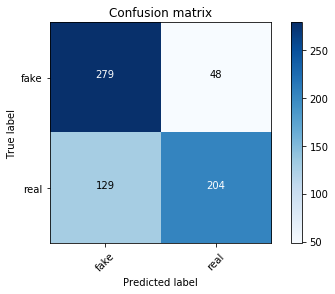

In [0]:
#Naive Bayes using tf-idf vectorizer
clf = MultinomialNB() 
clf.fit(tf_train, y_train)
pred = clf.predict(tf_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)

cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.721
F1_Measure: 0.719
Confusion matrix, without normalization


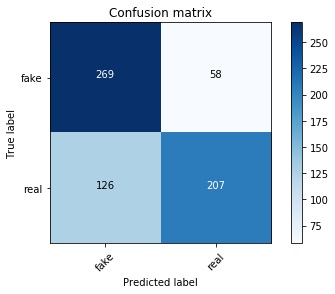

In [0]:
#Naive Bayes using count vectorizer
clf = MultinomialNB() 
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)

cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize
x=[]

for i in x_train["text"]:
    #y=data.loc[i,"content"]
    y=i
    word_tokens=word_tokenize(y)
    filtered_sentence=[]
    for w in word_tokens:
      if(w not in Stop_Words):
        filtered_sentence.append(w)
    x.append(filtered_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#training our word2vec model
model = gensim.models.Word2Vec(x, size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.items())))

    def fit(self, x, y):
        return self

    def transform(self, x):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in x
        ])



In [0]:
new_train=MeanEmbeddingVectorizer(w2v).transform(x_train["text"])

new_test=MeanEmbeddingVectorizer(w2v).transform(x_test["text"])

print(new_train.shape, type(new_train))
print(new_test.shape[0],new_test.shape[1])


(1338, 100) <class 'numpy.ndarray'>
660 100


In [0]:
u=np.zeros((1338,100)) #training data after applying word2vec transormation
v=np.zeros((660,100))  #testing data after applying word2vec transormation


for i in range(0,new_train.shape[0]):
  if(len(new_train[i])==100):
    for j in range(0,100):
      u[i][j]=new_train[i][j]

for i in range(0,new_test.shape[0]):
  if(len(new_test[i])==100):
    for j in range(0,100):
      v[i][j]=new_test[i][j]


In [0]:
u_normed = u/u.max(axis=0)
v_normed = v/v.max(axis=0)


accuracy:   0.547
F1_Measure: 0.546
Confusion matrix, without normalization


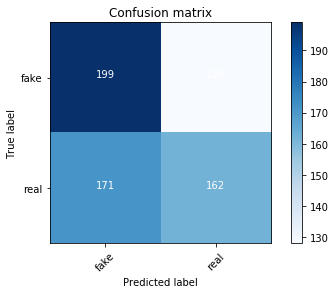

In [0]:
#RF with word2vec (only text features)
rf=RandomForestClassifier(n_estimators=100,max_depth=20,random_state=87)
rf.fit(u_normed,y_train)
pred=rf.predict(v_normed)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)



cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.761
F1_Measure: 0.760
Confusion matrix, without normalization


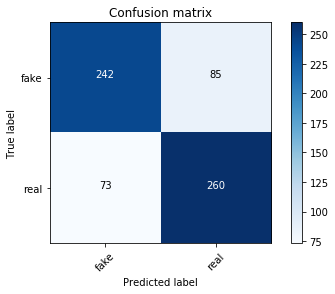

In [0]:
#RF with count-vectorizer (only text features)
rf=RandomForestClassifier(n_estimators=200,max_depth=100,random_state=87)
rf.fit(count_train, y_train)
pred = rf.predict(count_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.750
F1_Measure: 0.750
Confusion matrix, without normalization


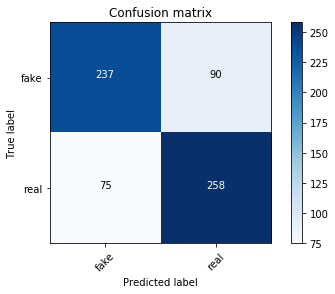

In [0]:
#RF with tf-idf-vectorizer(only text features)
rf=RandomForestClassifier(n_estimators=200,max_depth=200,random_state=87)
rf.fit(tf_train,y_train)
pred = rf.predict(tf_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

In [0]:
data.columns

Index(['news_item', 'text', 'tweets', 'retweet_count', 'favorite_count',
       'is_verified_count', 'mean_time_diff', 'popularity_score'],
      dtype='object')

In [0]:
data_user_train=x_train[[	'tweets', 'retweet_count', 'favorite_count','is_verified_count', 'mean_time_diff', 'popularity_score']]
data_user_train.head()


,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score
1652,45,47.0,43.0,2.0,2339.088889,1123088.0
942,86,2.0,0.0,0.0,1450.709302,14365.0
538,46,0.0,2.0,0.0,1059.630435,5969.0
183,27,0.0,0.0,0.0,1694.555556,55906.0
816,4,4.0,6.0,3.0,3304.500000,1003263.0


In [0]:
data_user_test=x_test[['tweets', 'retweet_count', 'favorite_count','is_verified_count', 'mean_time_diff', 'popularity_score']]
data_user_test.head()

,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score
708,21,6.0,26.0,4.0,1892.285714,1097167.0
267,6,0.0,1.0,2.0,1708.000000,669578.0
1269,48,2.0,2.0,0.0,913.250000,11038.0
1129,11,0.0,0.0,0.0,2068.545455,-6859.0
1848,23,0.0,0.0,0.0,1402.826087,55289.0


In [0]:
data.columns

Index(['news_item', 'text', 'tweets', 'retweet_count', 'favorite_count',
       'is_verified_count', 'mean_time_diff', 'popularity_score'],
      dtype='object')

In [0]:
print(len(x_train),len(x_test))

1338 660


In [0]:
data_user_train_norm = data_user_train.copy()
for feature_name in data_user_train.columns:
        max_value = data_user_train[feature_name].max()
        min_value = data_user_train[feature_name].min()
        data_user_train_norm[feature_name] = (data_user_train[feature_name] - min_value) / (max_value - min_value)


data_user_test_norm = data_user_test.copy()
for feature_name in data_user_test.columns:
        max_value = data_user_test[feature_name].max()
        min_value = data_user_test[feature_name].min()
        data_user_test_norm[feature_name] = (data_user_test[feature_name] - min_value) / (max_value - min_value)

      

In [0]:
tfidf_dense = tf_train.todense()
tfidf_dense2 = tf_test.todense()

data_user_train_norm=data_user_train_norm.reset_index(drop=True)
d=pd.DataFrame(tfidf_dense)
d1=pd.concat([d,data_user_train_norm],axis=1)

data_user_test_norm=data_user_test_norm.reset_index(drop=True)
t=pd.DataFrame(tfidf_dense2)
d2=pd.concat([t,data_user_test_norm],axis=1)
d2





,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,38476,38477,38478,38479,38480,38481,38482,38483,38484,38485,38486,38487,38488,38489,38490,38491,38492,38493,38494,38495,38496,38497,38498,38499,38500,38501,38502,38503,38504,38505,38506,38507,38508,38509,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009634,0.000757,0.001860,0.013378,0.544510,0.006138
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002408,0.000000,0.000072,0.006689,0.487955,0.003798
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022640,0.000252,0.000143,0.000000,0.244054,0.000193
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004817,0.000000,0.000000,0.000000,0.598602,0.000095
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010597,0.000000,0.000000,0.000000,0.394300,0.000435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003854,0.000000,0.000286,0.006689,0.683375,0.003770
656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001445,0.000378,0.000215,0.006689,0.831287,0.003795
657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103565,0.002396,0.002004,0.033445,0.184363,0.018006
658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021676,0.000126,0.000429,0.016722,0.443436,0.007707


In [0]:
d1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,38476,38477,38478,38479,38480,38481,38482,38483,38484,38485,38486,38487,38488,38489,38490,38491,38492,38493,38494,38495,38496,38497,38498,38499,38500,38501,38502,38503,38504,38505,38506,38507,38508,38509,tweets,retweet_count,favorite_count,is_verified_count,mean_time_diff,popularity_score
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027044,0.007323,0.001327,0.015267,0.610148,0.006132
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052243,0.000312,0.000000,0.000000,0.378317,0.001370
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027658,0.000000,0.000062,0.000000,0.276261,0.001334
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015980,0.000000,0.000000,0.000000,0.441951,0.001548
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001844,0.000623,0.000185,0.022901,0.862082,0.005617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.0,0.013831,0.004705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002459,0.000312,0.000062,0.015267,0.442850,0.004191
1334,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030731,0.001091,0.002006,0.022901,0.361732,0.009076
1335,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008605,0.000000,0.000000,0.000000,0.409882,0.001315
1336,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027044,0.0052

accuracy:   0.847
F1_Measure: 0.847
Confusion matrix, without normalization


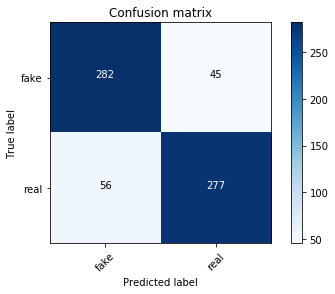

In [0]:
#Rf using using hybrid features(with tf-idf)
rf=RandomForestClassifier(n_estimators=300,max_depth=300,random_state=87)
rf.fit(d1,y_train)
pred=rf.predict(d2)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])



accuracy:   0.788
F1_Measure: 0.787
Confusion matrix, without normalization


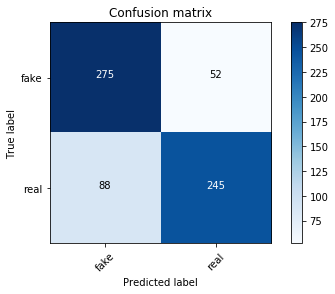

In [0]:
#RF with ONLY Social Context Features
rf=RandomForestClassifier(n_estimators=100,max_depth=100,random_state=87)
rf.fit(data_user_train_norm,y_train)
pred=rf.predict(data_user_test_norm)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)

cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.703
F1_Measure: 0.691
Confusion matrix, without normalization


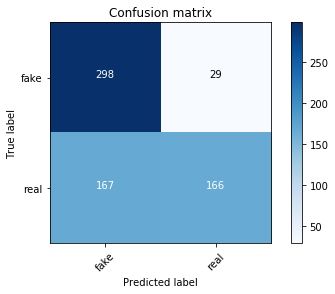

In [0]:
#Naive Bayes HYBRID FEATURES-tf-idf
clf = MultinomialNB() 
clf.fit(d1, y_train)
pred = clf.predict(d2)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.539
F1_Measure: 0.509
Confusion matrix, without normalization


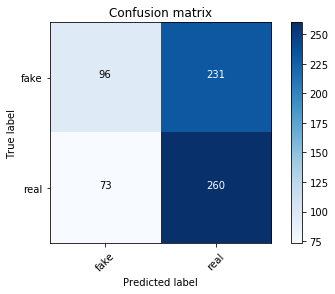

In [0]:
#Naive Bayes SOCIAL CONTEXT 
clf = MultinomialNB() 
clf.fit(data_user_train_norm, y_train)
pred = clf.predict(data_user_test_norm)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.736
F1_Measure: 0.734
Confusion matrix, without normalization


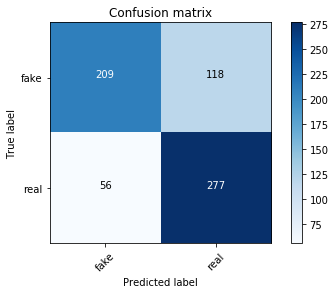

In [0]:
#xgboost-countvectorizer-ONLY TEXT
from xgboost import XGBClassifier
clf=XGBClassifier()
clf.fit(count_train,y_train)
pred=clf.predict(count_test)
score = accuracy_score(y_test,pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])



accuracy:   0.727
F1_Measure: 0.725
Confusion matrix, without normalization


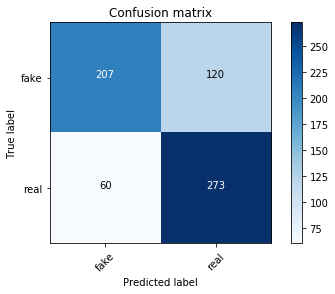

In [0]:
#xgboost-tf-idf-vectorizer-ONLY TEXT
from xgboost import XGBClassifier
clf=XGBClassifier()
clf.fit(tf_train,y_train)
pred=clf.predict(tf_test)
score = accuracy_score(y_test,pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])



accuracy:   0.555
F1_Measure: 0.501
Confusion matrix, without normalization


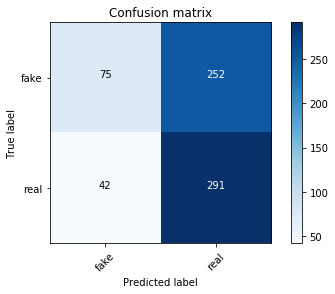

In [0]:
#xgboost-wor2vec vectorizer-ONLY TEXT
from xgboost import XGBClassifier
clf=XGBClassifier()
clf.fit(u_normed,y_train)
pred=clf.predict(v_normed)
score = accuracy_score(y_test,pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])



accuracy:   0.805
F1_Measure: 0.804
Confusion matrix, without normalization


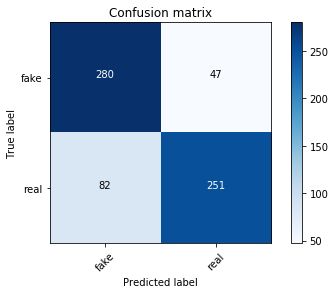

In [0]:
#xgboost-ONLY SOCIAL FEATURES

from xgboost import XGBClassifier
clf=XGBClassifier()
clf.fit(data_user_train_norm,y_train)
pred=clf.predict(data_user_test_norm)
score = accuracy_score(y_test,pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])




accuracy:   0.855
F1_Measure: 0.855
Confusion matrix, without normalization


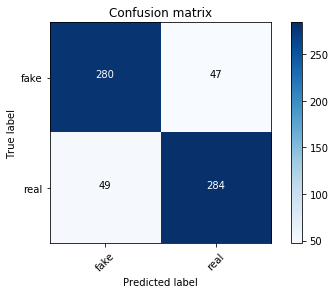

In [0]:
#xgboost-HYBRID FEATURES

from xgboost import XGBClassifier
clf=XGBClassifier()
clf.fit(d1,y_train)
pred=clf.predict(d2)
score = accuracy_score(y_test,pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])




accuracy:   0.747
F1_Measure: 0.747
Confusion matrix, without normalization


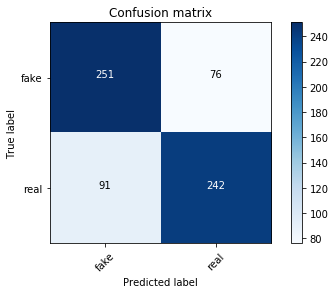

In [0]:
#passive aggressive-count vectorizer-ONLY TEXT
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=10,tol=1e-3)
clf.fit(count_train,y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.765
F1_Measure: 0.764
Confusion matrix, without normalization


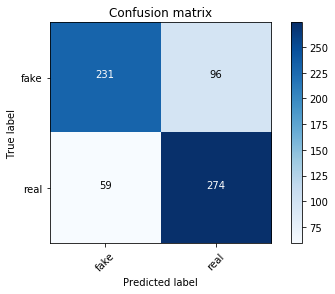

In [0]:
#passive aggressive-tf-idf-vectorizer-ONLY TEXT
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3)
clf.fit(tf_train,y_train)
pred = clf.predict(tf_test)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.505
F1_Measure: 0.335
Confusion matrix, without normalization


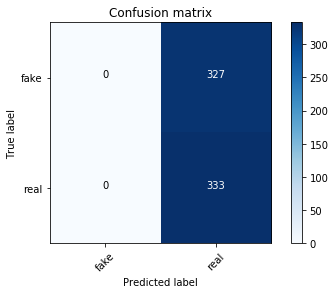

In [0]:
#passive aggressive-word2vec-ONLY TEXT
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3)
clf.fit(u_normed,y_train)
pred = clf.predict(v_normed)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.573
F1_Measure: 0.531
Confusion matrix, without normalization


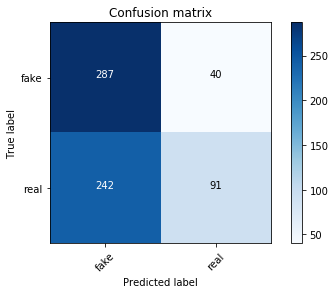

In [0]:
#passive aggressive-ONLY SOCIAL FEATURES
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=2000, random_state=87,tol=1e-3)
clf.fit(data_user_train_norm,y_train)
pred = clf.predict(data_user_test_norm)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

accuracy:   0.800
F1_Measure: 0.800
Confusion matrix, without normalization


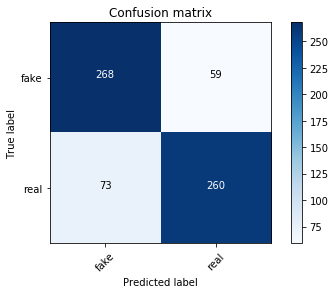

In [0]:
#passive aggressive-HYBRID FEATURES
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=87,tol=1e-3)
clf.fit(d1,y_train)
pred = clf.predict(d2)
score = accuracy_score(y_test, pred)
f1=f1_score(y_test, pred, average='macro')
print("accuracy:   %0.3f" % score)
print("F1_Measure: %0.3f" % f1)


cm = confusion_matrix(y_test, pred, labels=['fake', 'real'])
plot_confusion_matrix(cm, classes=['fake', 'real'])

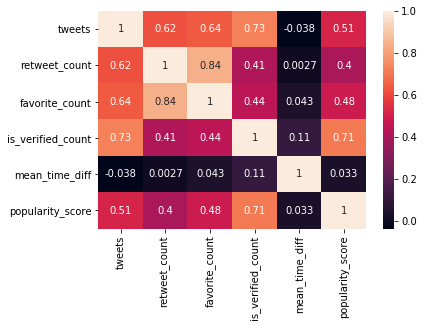

In [0]:
#plotting the correlation heat map
import seaborn as sns

Var_Corr = data_user_train_norm.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)